### Consider the streaming setting. At this point, we focus on the coverage of the true nulls. (Since we haven't discussed about how to deal with the outliers detected at time t).  We are under the naive setting where the outlier detected at time t (i.e., with p value < 5%) is not removed for future predictions. For simplicity, suppose we have a Gaussian sequence $Y = 0 + N(0,1)$ with known mean = 0. The score will then be $|Y_t|$. The outliers drawn i.i.d. from $N(2, 1)$

##### * The codes are modified from Zixuan's notebook
#### a) Fixed number of outliers. Toy example: We have 100 outliers at time $0, \cdots, 99$. What is the coverage (average over  10 streams) at time t? 

In [96]:
import numpy as np
import matplotlib.pyplot as plt

def coverage_at_t_fixed(t, mu = 2, alpha = 0.05): ## t>= 100
    seq = np.concatenate((np.random.normal(mu, 1, 100), np.random.normal(0, 1, t-100)))
    result = []
    for i in range(100, t+1):
        abs_seq =  abs(seq[0:i+1])
        comparison = abs_seq < abs_seq[-1]
        result.append(sum(comparison) <= (1 - alpha) * len(abs_seq))
    return sum(result)/(t-99)

In [95]:
marginals = []
for t in [250, 500, 750, 1000, 1250, 1500, 1750, 2000]:
    marginals.append(np.mean([coverage_at_t_fixed(t) for _ in range(10)]))
        

KeyboardInterrupt: 

In [44]:
 marginals.append(np.mean([coverage_at_t_fixed(5000) for _ in range(10)]))

Text(0, 0.5, 'coverage')

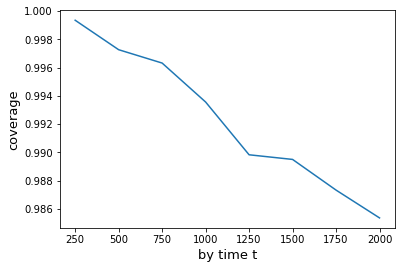

In [47]:
plt.plot([250, 500, 750, 1000, 1250, 1500, 1750, 2000], marginals[0:-1])
plt.xlabel('by time t', size = 13)
plt.ylabel('coverage', size = 13)

In [62]:
marginals[-1]

0.9705774331769026

In [101]:
marginals 

[0.9986754966887418,
 0.9970074812967582,
 0.9946236559139784,
 0.9932297447280799,
 0.9891398783666376,
 0.9875802997858673,
 0.9854027861901876]

#### We observe that we are more conservative at an earlier t than at a later t (target coverage is 0.95). Intuitively the effect of the outliers diminish as more nulls adding in. At t = 5000, the coverage is about 0.97

#### What if the outliers are further away from the true distribution? That is, drawn from $N(10, 1)$

Text(0, 0.5, 'coverage')

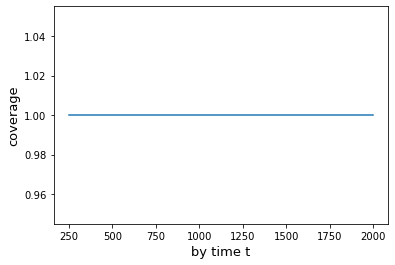

In [50]:
marginals_v2 = []
for t in [250, 500, 750, 1000, 1250, 1500, 1750, 2000]:
    marginals_v2.append(np.mean([coverage_at_t_fixed(t, mu = 10) for _ in range(10)]))
    
plt.plot([250, 500, 750, 1000, 1250, 1500, 1750, 2000], marginals_v2)
plt.xlabel('by time t', size = 13)
plt.ylabel('coverage', size = 13)

#### We have coverge = 1 (no nulls rejected) . The explanation is that the outliers are very large so they are always in the upper tail. We have 100 outliers and they mostly occupy the $100/2000 = 0.05$ upper tail so we won't reject any nulls until a later t

#### b) Now consider we have a fixed fraction of outliers. Naturally, at time t, we flip a coin to determine whether $Y_t$ is from the null or not. Let's start with 5% chance of outliers drawn from $N(10, 1)$ far away from nulls ($N(0, 1)$)

In [99]:
def coverage_at_t_random(t, mu = 2, alpha = 0.05, p = 0.05): ## t>= 100
    
    z = np.random.uniform(0, 1, t) >= p
    seq = np.random.normal(0, 1, t) * (z) + np.random.normal(mu, 1, t) * (1-z)
    result = []
    for i in range(t):
        abs_seq =  abs(seq[0:i+1])
        comparison = abs_seq < abs_seq[-1]
        result.append(sum(comparison) <= (1 - alpha) * len(abs_seq))
    null_size = sum(z) 
    return sum(np.array(result)[z])/null_size

Text(0, 0.5, 'coverage')

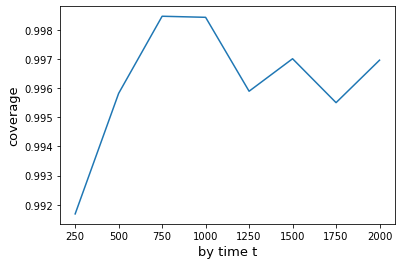

In [100]:
m3 = []
for t in [250, 500, 750, 1000, 1250, 1500, 1750, 2000]:
    m3.append(np.mean([coverage_at_t_random(t, mu = 10) for _ in range(10)]))
    
plt.plot([250, 500, 750, 1000, 1250, 1500, 1750, 2000], m3)
plt.xlabel('by time t', size = 13)
plt.ylabel('coverage', size = 13)

#### So the coverage is very close to 1. It suggests that the prediction intervel becomes trivial for the nulls (Too loose). To visualize, we can see that: (Intuitively, if the outliers are very far away from nulls, we need to reject at $p + \alpha$ to achieve $\alpha$ coverage

In [102]:
t = 1000
p = 0.05
alpha = 0.05
mu = 10
np.random.seed(123)
z = np.random.uniform(0, 1, t) >= p
seq = np.random.normal(0, 1, t) * (z) + np.random.normal(mu, 1, t) * (1-z)

In [109]:
h = np.quantile(np.abs(seq), 0.95)

Text(0.5, 1.0, '0.95 quantile for t = 1000')

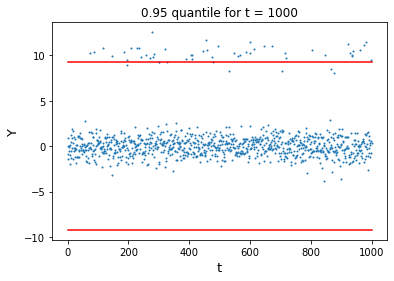

In [117]:
plt.scatter(range(t), seq, s = 1)
plt.plot([0, 1000], [h, h], color = 'red')
plt.plot([0, 1000], [-h, -h], color = 'red')
plt.xlabel('t', size = 13)
plt.ylabel('Y', size = 13)
plt.title('0.95 quantile for t = 1000')

#### The prediction interval is quite loose. The problem is that $\alpha$ is small, so even a small fraction of outliers can ruin the whole test. On the other hand, it seems that in the case above, the outliers can be detected very easily. How should we modify this procedure? 